# Case Study 3 : Data Science in OpenAI Games

**Required Readings:** 
* [Deep Reinforcement Learning](http://karpathy.github.io/2016/05/31/rl/) 
* [OpenAI](https://gym.openai.com/)
* [TED Talks](https://www.ted.com/talks) for examples of 10 minutes talks.

** NOTE **
* In this case study, you will need to use Mac OS or Linux system. In windows computers, you could use virtualbox to create a virtual machine and install an Ubuntu OS in the virtual machine.
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.

*----------------------

# Problem: pick a data science problem that you plan to solve using OpenAI Games
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using the openAI game system and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

# Data Exploration: Exploring the OpenAI Game System (Gym)

**1. Playing Pacman** 
We first introduce an example of how to use the gym package from OpenAI to design an agent for Pacman Game.
In the following cell, we implemented a simple agent, which randomly picks the next action without looking at the screen image (i.e., the *observation*) or the reward.

Change the following code for **myAgent** to design a better agent, which takes the observation and reward as the input and picks the best action as the next move.
The agent should be able to improve itself after playing more games.

***The goals***: Implement an agent using neural networks that can achieve all the following goals:
* (a) move the PacMan in all directions.  (5 points)
* (b) using neural network to decide what is the best next move. (5 points)
* (c) after playing each episode of the game, the agent should be able to improve itself using the experience. (5 points)

Action Code:
* 1 - UP
* 2 - RIGHT
* 3 - LEFT
* 4 - DOWN

In [34]:
#
# 1) image manipulation/cropping/removing colors etc...
#    strip down image for easier manipulation and cleaner evaluation
#    used by agent
#
## SOURCE: https://raw.githubusercontent.com/dhruvp/atari-pong/master/me_pong.py
## ARTICLE: https://medium.com/@dhruvp/how-to-write-a-neural-network-to-play-pong-from-scratch-956b57d4f6e0#.frsvhcp2c
import numpy as np

def crop(image):
    return image[35:195]

def downsample(image):
    # Take only alternate pixels - basically halves the resolution of the image (which is fine for us)
    return image[::2, ::2, :]


def remove_color(image):
    """Convert all color (RGB is the third dimension in the image)"""
    return image[:, :, 0]


def remove_background(image):
    image[image == 144] = 0
    image[image == 109] = 0
    return image


def process_image(image):
    """ convert the 210x160x3 uint8 frame into a 6400 float vector """
    result = crop(image)
    result = downsample(result)
    result = remove_color(result)
    result = remove_background(result)

    result[result != 0] = 1 #set all other areas to '1'
    return result.astype(np.float).ravel()

def get_image_difference(current_image, prev_image):
    """ obtain difference between current and previous image """
    if prev_image is None: #no difference no previous
        return np.zeros(current_image.size)
    else:
        return current_image - prev_image
    return diff_image


In [35]:
#
# 2) Neural Network used to make selection
#   2 layer neural network with weights
#   1st layer evaluates image
#   2nd layer condenses result into a floating point value between 0 and 1
#   This network is used by the agent to make action selection.
#
## SOURCE: https://raw.githubusercontent.com/dhruvp/atari-pong/master/me_pong.py
## ARTICLE: https://medium.com/@dhruvp/how-to-write-a-neural-network-to-play-pong-from-scratch-956b57d4f6e0#.frsvhcp2c
import numpy as np


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def relu(vector):
    vector[vector < 0] = 0
    return vector


class NeuralNetwork(object):
    '''The Neural Network with 2 layers'''

    def __init__(self, image_size, num_hidden_layer_neurons):
        self.history_images = []
        self.history_hidden_values=[]
        self.image_size = image_size
        self.num_hidden_layer_neurons = num_hidden_layer_neurons
        self.num_inner_layers = 2
        self.weights={}
        self.weights['1'] = np.random.randn(self.num_hidden_layer_neurons, self.image_size) / np.sqrt(self.image_size)
        self.weights['2'] = np.random.randn(self.num_hidden_layer_neurons) / np.sqrt(self.num_hidden_layer_neurons)
        if self.image_size == 1:
            self.weights['1'] = self.weights['1'].ravel()

    def clearHistory(self):
        self.history_images = []
        self.history_hidden_values = []

    def apply(self, image):
        '''choose action based on passed image using a neural network'''
        hidden_layer_values = image
        hidden_layer_results = []
        for i in range(self.num_inner_layers - 1):
            hidden_layer_values = np.dot(self.weights[str(i+1)], hidden_layer_values)
            hidden_layer_values = relu(hidden_layer_values)
            hidden_layer_results.append(hidden_layer_values)

        output_layer_values = np.dot(hidden_layer_values, self.weights[str(self.num_inner_layers)])
        action_probability = sigmoid(output_layer_values)
        self.history_images.append(image)
        self.history_hidden_values.append(hidden_layer_results)
        return action_probability


In [36]:
#
# 3) Teacher - learn from play
#    Takes the history of episode play, observations,  neural network layer values, reward results
#    updates weights in Neural Network
#    This is used by agent to 'learn'
#    
## SOURCE: https://raw.githubusercontent.com/dhruvp/atari-pong/master/me_pong.py
## ARTICLE: https://medium.com/@dhruvp/how-to-write-a-neural-network-to-play-pong-from-scratch-956b57d4f6e0#.frsvhcp2c

import numpy as np

def compute_gradient(gradient_log_p, hidden_layer_values, observation_values, weights):
    '''compute gradient for weights'''
    delta_L = gradient_log_p
    dC_dw2 = np.dot(hidden_layer_values.T, delta_L).ravel()
    delta_l2 = np.outer(delta_L, weights['2'])
    delta_l2 = relu(delta_l2)
    dC_dw1 = np.dot(delta_l2.T, observation_values)
    if len(weights['1'].shape) == 1:
        dC_dw1 = dC_dw1.ravel()
    return {
        '1': dC_dw1,
        '2': dC_dw2
    }


def update_weights(weights, expectation_g_squared, g_dict, decay_rate, learning_rate):
    '''update weights based on learning rate and expectation decay'''
    epsilon = 1e-5
    for layer_name in weights.keys():
        g = g_dict[layer_name]
        expectation_g_squared[layer_name] = decay_rate * expectation_g_squared[layer_name] + (1 - decay_rate) * g ** 2
        weights[layer_name] += (learning_rate * g) / (np.sqrt(expectation_g_squared[layer_name] + epsilon))
        g_dict[layer_name] = np.zeros_like(weights[layer_name])  # reset batch gradient buffer


def discount_rewards(rewards, gamma):
    '''discount the rewards based on progression through game'''
    discounted_rewards = np.zeros_like(rewards, dtype=np.float64)
    running_add = 0
    for t in reversed(range(0, rewards.size)):
        #if rewards[t] != 0:
            #running_add = 0  # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = float(running_add)
    return discounted_rewards


def discount_with_rewards(gradient_log_p, episode_rewards):
    """ discount the gradient with the normalized rewards """
    gamma = 0.99  # discount factor for reward
    discounted_episode_rewards = discount_rewards(episode_rewards, gamma)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_episode_rewards -= np.mean(discounted_episode_rewards)
    discounted_episode_rewards /= np.std(discounted_episode_rewards)
    return gradient_log_p * discounted_episode_rewards




class Teacher(object):
    '''Teacher to teach the agent how to play better next time.'''
    def __init__(self, agent):
        self.episode_number = 0
        self.batch_size = 10
        self.decay_rate = 0.99
        self.learning_rate = 1e-4
        self.agent = agent
        self.neural_network = agent.neural_network
        self.expectation_g_squared = {}
        self.dict = {}
        for layer_name in self.neural_network.weights.keys():
            self.expectation_g_squared[layer_name] = np.zeros_like(self.neural_network.weights[layer_name])
            self.dict[layer_name] = np.zeros_like(self.neural_network.weights[layer_name])

    def train(self):
        '''collect the history of what happened this past episode'''
        episode_hidden_layer_values = np.vstack(self.neural_network.history_hidden_values)
        episode_observations = np.vstack(self.neural_network.history_images)
        episode_gradient_log_ps = np.vstack(self.agent.history_loss_func_gradients)
        episode_rewards = np.vstack(self.agent.history_rewards)

        # adjust gradients based on rewards collected
        episode_gradient_log_ps_discounted = discount_with_rewards(episode_gradient_log_ps, episode_rewards)

        #compute gradient for each weight layer
        gradient = compute_gradient(
            episode_gradient_log_ps_discounted,
            episode_hidden_layer_values,
            episode_observations,
            self.neural_network.weights
        )

        # Sum the gradient for use when we hit the batch size
        for layer_name in gradient:
            self.dict[layer_name] += gradient[layer_name]

        if self.episode_number % self.batch_size == 0:
            update_weights(self.neural_network.weights, self.expectation_g_squared, self.dict, self.decay_rate, self.learning_rate)
        self.episode_number += 1

In [37]:
#
# 4) Intelligent Agent - plays the game and learns
#    Each iteration in an episode this agent will make an action choice
#    based on the result of the neural network. The action 'probability' value
#    returned by the Neural Network is used to make 1 of 4 action choices.
#    selection is:  ceil(MaxPossibleActions * neuralNetworkProbability)
#    this results in a value of 1 -> 4
#
## SOURCE: https://raw.githubusercontent.com/dhruvp/atari-pong/master/me_pong.py
## ARTICLE: https://medium.com/@dhruvp/how-to-write-a-neural-network-to-play-pong-from-scratch-956b57d4f6e0#.frsvhcp2c

import math

class myIntelligentAgent(object):
    '''The intelligent Agent. Uses neural network to make selection, and learns from episode play'''
    def __init__(self, env, num_hidden_layer_neurons, max_possible_actions):
        self.env = env
        self.num_hidden_layer_neurons = num_hidden_layer_neurons
        self.max_possible_actions = float(max_possible_actions)
        self.last_processed_observation = None
        self.last_action_percentage = None
        self.last_action = None
        self.neural_network = None
        self.history_rewards = []
        self.history_loss_func_gradients = []
        self.teacher = None

    def clearHistory(self):
        self.last_processed_observation = None
        self.last_action_percentage = None
        self.last_action = None
        self.history_rewards = []
        self.history_loss_func_gradients = []
        self.neural_network.clearHistory()

    def pick_next_action(self, observation):
        """ observation is the current screen image. reward is the current reward in the time step """
        processed_observation = self.process_observation(observation)
        if self.neural_network is None:
            self.neural_network = NeuralNetwork(processed_observation.size, self.num_hidden_layer_neurons)
        action_percentage = self.neural_network.apply(processed_observation)
        action = math.ceil(self.max_possible_actions * action_percentage)
        fake_label = float(action)
        loss_function_gradient = fake_label - (self.max_possible_actions * action_percentage)
        self.history_loss_func_gradients.append(loss_function_gradient)

        self.last_action = action
        self.last_action_percentage = action_percentage
        return action

    def post_reward(self, reward):
        self.history_rewards.append(reward)
        
    def process_observation(self, input_observation):
        """ process observation obtain diff from last"""
        processed_observation = process_image(input_observation)
        result = get_image_difference(processed_observation, self.last_processed_observation)
        self.last_processed_observation = processed_observation
        return result

    def learn(self):
        ''' using the teacher learn'''
        if self.teacher is None:
            self.teacher = Teacher(self)
        self.teacher.train()
        self.clearHistory()


[2017-03-12 23:27:36,027] Making new env: MsPacman-v0


Episode 10000/10000 reward 210.0

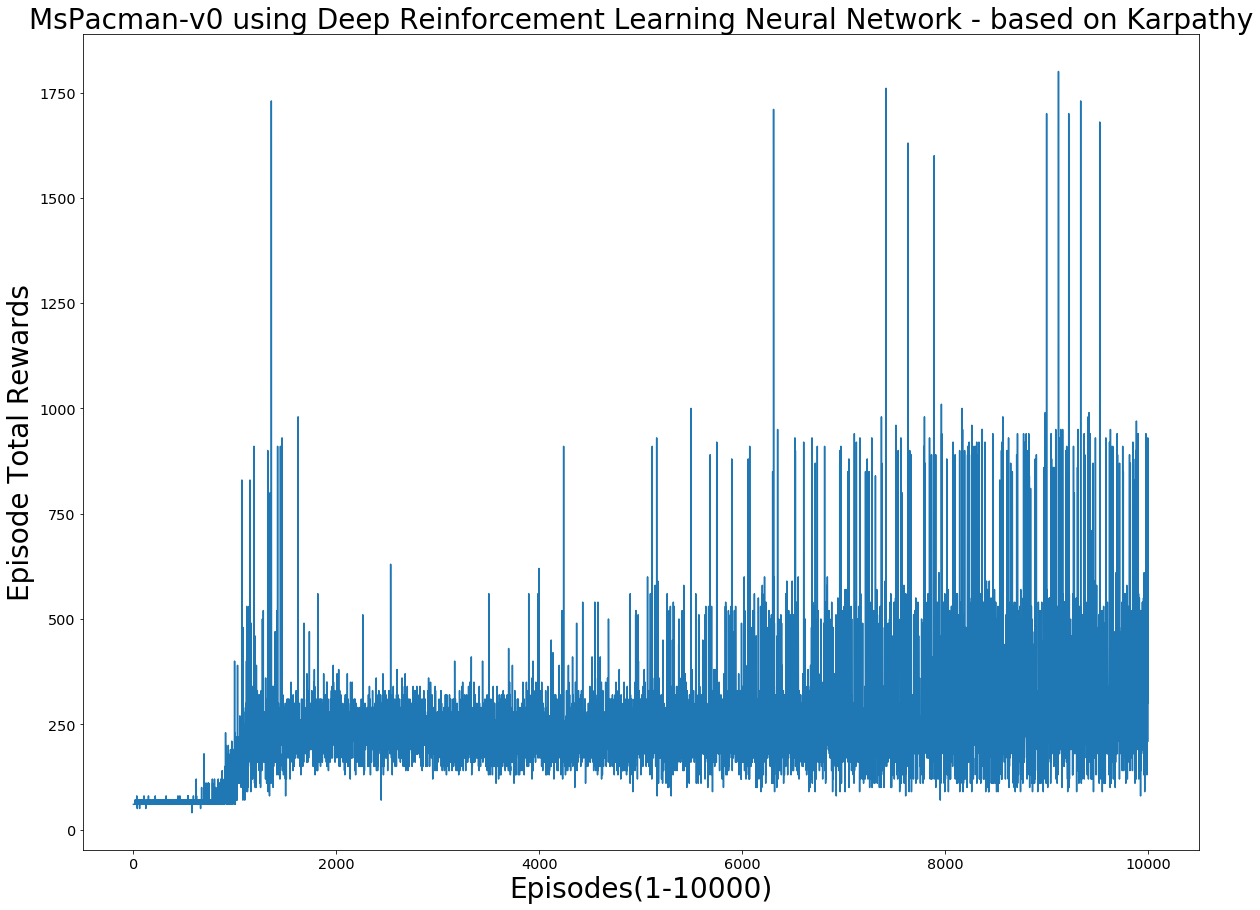

In [42]:
#
# 5) Play the Game with intelligent agent
#    Change out 'random' agent with intelligent agent
#    add-in learning
import gym
import sys
import matplotlib.pyplot as plt

num_episodes = 10000  # how many episodes to play
render = False  # whether to render the game. You should turn this off to speed up the program.


env = gym.make('MsPacman-v0')  # create the game envirement
agent = myIntelligentAgent(env, 200, 4)  # create an agent
episode_reward_history=[]

# let's play some episodes of the game

for episode in range(num_episodes):
    observation = env.reset()  # initialize the game
    episode_reward = 0  # the sum of rewards in an episode
    action = env.action_space.sample()  # RANDOMLY pick an action for the next move
    observation, reward, done, info = env.step(action)  # execute the action and get the reward and next observation
    reward = None
    while not done:
        if render:
            env.render()  # render the game
        action = agent.pick_next_action(observation)
        observation, reward, done, info = env.step(action)
        agent.post_reward(reward)
        episode_reward += reward  # adding up the reward in the episode
        if done:  # the episode is done
            episode_reward_history.append(episode_reward)
            sys.stdout.write('\rEpisode {}/{} reward {}'.format((episode+1), num_episodes, episode_reward))
            sys.stdout.flush()
            agent.learn()
arams = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.plot(episode_reward_history)
plt.rcParams.update(params)
plt.title('MsPacman-v0 using Deep Reinforcement Learning Neural Network - based on Karpathy', fontsize=28)
plt.ylabel('Episode Total Rewards', fontsize=28)
plt.xlabel('Episodes(1-%d)'%len(episode_reward_history), fontsize=28)
plt.show()


# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

In [ ]:
The driverless taxi service C-uber (cyber-uber) could be, initially, based on the Open AI gym Taxi environment 
(https://gym.openai.com/envs/Taxi-v1).
This environment will be coupled with the neural network and learning algorithms leveraged in our 'Ms PacMan' 
data exploration task to show how far away we are from achieving this driverless taxi service.

In [47]:
#
# 1) Neural Network used to make selection
#   2 layer neural network with weights
#   1st layer evaluates state
#   2nd layer condenses result into a floating point value between 0 and 1
#   This network is used by the agent to make action selection.
#
## SOURCE: https://raw.githubusercontent.com/dhruvp/atari-pong/master/me_pong.py
## ARTICLE: https://medium.com/@dhruvp/how-to-write-a-neural-network-to-play-pong-from-scratch-956b57d4f6e0#.frsvhcp2c
import numpy as np


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


def relu(vector):
    vector[vector < 0] = 0
    return vector


class NeuralNetwork(object):
    '''The Neural Network with 2 layers'''

    def __init__(self, image_size, num_hidden_layer_neurons):
        self.history_images = []
        self.history_hidden_values=[]
        self.image_size = image_size
        self.num_hidden_layer_neurons = num_hidden_layer_neurons
        self.num_inner_layers = 2
        self.weights={}
        self.weights['1'] = np.random.randn(self.num_hidden_layer_neurons, self.image_size) / np.sqrt(self.image_size)
        self.weights['2'] = np.random.randn(self.num_hidden_layer_neurons) / np.sqrt(self.num_hidden_layer_neurons)
        if self.image_size == 1:
            self.weights['1'] = self.weights['1'].ravel()

    def clearHistory(self):
        self.history_images = []
        self.history_hidden_values = []

    def apply(self, image):
        '''choose action based on passed image using a neural network'''
        hidden_layer_values = image
        hidden_layer_results = []
        for i in range(self.num_inner_layers - 1):
            hidden_layer_values = np.dot(self.weights[str(i+1)], hidden_layer_values)
            hidden_layer_values = relu(hidden_layer_values)
            hidden_layer_results.append(hidden_layer_values)

        output_layer_values = np.dot(hidden_layer_values, self.weights[str(self.num_inner_layers)])
        action_probability = sigmoid(output_layer_values)
        self.history_images.append(image)
        self.history_hidden_values.append(hidden_layer_results)
        return action_probability


In [48]:
#
# 2) Teacher - learn from play
#    Takes the history of episode play, observations,  neural network layer values, reward results
#    updates weights in Neural Network
#    This is used by agent to 'learn'
#    
## SOURCE: https://raw.githubusercontent.com/dhruvp/atari-pong/master/me_pong.py
## ARTICLE: https://medium.com/@dhruvp/how-to-write-a-neural-network-to-play-pong-from-scratch-956b57d4f6e0#.frsvhcp2c

import numpy as np

def compute_gradient(gradient_log_p, hidden_layer_values, observation_values, weights):
    '''compute gradient for weights'''
    delta_L = gradient_log_p
    dC_dw2 = np.dot(hidden_layer_values.T, delta_L).ravel()
    delta_l2 = np.outer(delta_L, weights['2'])
    delta_l2 = relu(delta_l2)
    dC_dw1 = np.dot(delta_l2.T, observation_values)
    if len(weights['1'].shape) == 1:
        dC_dw1 = dC_dw1.ravel()
    return {
        '1': dC_dw1,
        '2': dC_dw2
    }


def update_weights(weights, expectation_g_squared, g_dict, decay_rate, learning_rate):
    '''update weights based on learning rate and expectation decay'''
    epsilon = 1e-5
    for layer_name in weights.keys():
        g = g_dict[layer_name]
        expectation_g_squared[layer_name] = decay_rate * expectation_g_squared[layer_name] + (1 - decay_rate) * g ** 2
        weights[layer_name] += (learning_rate * g) / (np.sqrt(expectation_g_squared[layer_name] + epsilon))
        g_dict[layer_name] = np.zeros_like(weights[layer_name])  # reset batch gradient buffer


def discount_rewards(rewards, gamma):
    '''discount the rewards based on progression through game'''
    discounted_rewards = np.zeros_like(rewards, dtype=np.float64)
    running_add = 0
    for t in reversed(range(0, rewards.size)):
        #if rewards[t] != 0:
            #running_add = 0  # reset the sum, since this was a game boundary (pong specific!)
        running_add = running_add * gamma + rewards[t]
        discounted_rewards[t] = float(running_add)
    return discounted_rewards


def discount_with_rewards(gradient_log_p, episode_rewards):
    """ discount the gradient with the normalized rewards """
    gamma = 0.99  # discount factor for reward
    discounted_episode_rewards = discount_rewards(episode_rewards, gamma)
    # standardize the rewards to be unit normal (helps control the gradient estimator variance)
    discounted_episode_rewards -= np.mean(discounted_episode_rewards)
    discounted_episode_rewards /= np.std(discounted_episode_rewards)
    return gradient_log_p * discounted_episode_rewards




class Teacher(object):
    '''Teacher to teach the agent how to play better next time.'''
    def __init__(self, agent):
        self.episode_number = 0
        self.batch_size = 10
        self.decay_rate = 0.99
        self.learning_rate = 1e-4
        self.agent = agent
        self.neural_network = agent.neural_network
        self.expectation_g_squared = {}
        self.dict = {}
        for layer_name in self.neural_network.weights.keys():
            self.expectation_g_squared[layer_name] = np.zeros_like(self.neural_network.weights[layer_name])
            self.dict[layer_name] = np.zeros_like(self.neural_network.weights[layer_name])

    def train(self):
        '''collect the history of what happened this past episode'''
        episode_hidden_layer_values = np.vstack(self.neural_network.history_hidden_values)
        episode_observations = np.vstack(self.neural_network.history_images)
        episode_gradient_log_ps = np.vstack(self.agent.history_loss_func_gradients)
        episode_rewards = np.vstack(self.agent.history_rewards)

        # adjust gradients based on rewards collected
        episode_gradient_log_ps_discounted = discount_with_rewards(episode_gradient_log_ps, episode_rewards)

        #compute gradient for each weight layer
        gradient = compute_gradient(
            episode_gradient_log_ps_discounted,
            episode_hidden_layer_values,
            episode_observations,
            self.neural_network.weights
        )

        # Sum the gradient for use when we hit the batch size
        for layer_name in gradient:
            self.dict[layer_name] += gradient[layer_name]

        if self.episode_number % self.batch_size == 0:
            update_weights(self.neural_network.weights, self.expectation_g_squared, self.dict, self.decay_rate, self.learning_rate)
        self.episode_number += 1

In [49]:
#
# 3) Intelligent Agent - plays the game and learns
#    Each iteration in an episode this agent will make an action choice
#    based on the result of the neural network. The action 'probability' value
#    returned by the Neural Network is used to make 1 of 4 action choices.
#    selection is:  ceil(MaxPossibleActions * neuralNetworkProbability)
#    this results in a value of 1 -> 4
#
## SOURCE: https://raw.githubusercontent.com/dhruvp/atari-pong/master/me_pong.py
## ARTICLE: https://medium.com/@dhruvp/how-to-write-a-neural-network-to-play-pong-from-scratch-956b57d4f6e0#.frsvhcp2c

import math

class myTaxiAgent(object):
    '''The intelligent Agent. Uses neural network to make selection, and learns from episode play'''
    def __init__(self, env, observation_space_size, max_possible_actions):
        self.env = env
        self.observation_space_size = observation_space_size
        self.max_possible_actions = float(max_possible_actions)
        self.last_processed_observation = None
        self.last_action_percentage = None
        self.last_action = None
        self.neural_network = None
        self.history_rewards = []
        self.history_loss_func_gradients = []
        self.teacher = None

    def clearHistory(self):
        self.last_processed_observation = None
        self.last_action_percentage = None
        self.last_action = None
        self.history_rewards = []
        self.history_loss_func_gradients = []
        self.neural_network.clearHistory()

    def pick_next_action(self, observation):
        """ observation is the current screen image. reward is the current reward in the time step """
        if self.neural_network is None:
            self.neural_network = NeuralNetwork(1, self.observation_space_size)
        action_percentage = self.neural_network.apply(observation)
        action = math.ceil(self.max_possible_actions * action_percentage) - 1
        fake_label = float(action+1)
        loss_function_gradient = fake_label - (self.max_possible_actions * action_percentage)
        self.history_loss_func_gradients.append(loss_function_gradient)

        self.last_action = action
        self.last_action_percentage = action_percentage
        return action

    def post_reward(self, reward):
        self.history_rewards.append(reward)
        
    def process_observation(self, input_observation):
        """ process observation obtain diff from last"""
        processed_observation = process_image(input_observation)
        result = get_image_difference(processed_observation, self.last_processed_observation)
        self.last_processed_observation = processed_observation
        return result

    def learn(self):
        ''' using the teacher learn'''
        if self.teacher is None:
            self.teacher = Teacher(self)
        self.teacher.train()
        self.clearHistory()


[2017-03-13 01:25:56,232] Making new env: Taxi-v2


Episode 10000/10000 reward -5000 quit

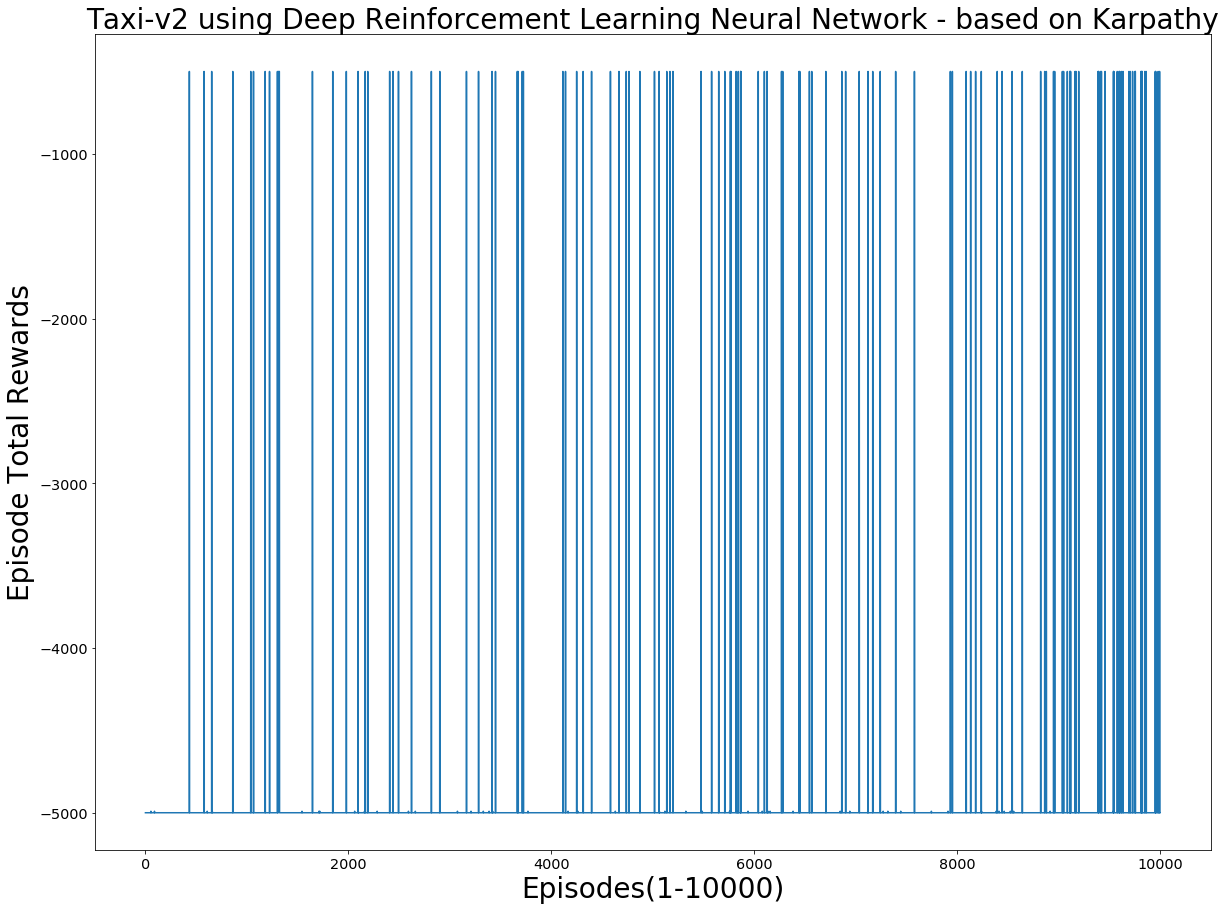

In [46]:
#
# 4) Play the Game with intelligent agent
#    Change out 'random' agent with intelligent agent
#    add-in learning
import gym
import sys
import matplotlib.pyplot as plt

num_episodes = 10000  # how many episodes to play
render = False  # whether to render the game. You should turn this off to speed up the program.


env = gym.make('Taxi-v2')  # create the game envirement
agent = myTaxiAgent(env, 500, 6)  # create an agent
episode_reward_history=[]

# let's play some episodes of the game

for episode in range(num_episodes):
    observation = env.reset()  # initialize the game
    episode_reward = 0  # the sum of rewards in an episode
    action = env.action_space.sample()  # RANDOMLY pick an action for the next move
    observation, reward, done, info = env.step(action)  # execute the action and get the reward and next observation
    reward = None
    moves = 0
    while moves < 500:
        moves += 1
        if render:
            env.render()  # render the game
        action = agent.pick_next_action(observation)
        observation, reward, done, info = env.step(action)
        agent.post_reward(reward)
        episode_reward += reward  # adding up the reward in the episode
        if done:  # the episode is done
            break;
    episode_reward_history.append(episode_reward)
    sys.stdout.write('\rEpisode {}/{} reward {} {}'.format((episode+1), num_episodes, episode_reward,  ('finished' if done else 'quit')))
    sys.stdout.flush()
    agent.learn()
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 15),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.plot(episode_reward_history)
plt.rcParams.update(params)

plt.title('Taxi-v2 using Deep Reinforcement Learning Neural Network - based on Karpathy', fontsize=28)
plt.ylabel('Episode Total Rewards', fontsize=28)
plt.xlabel('Episodes(1-%d)'%len(episode_reward_history), fontsize=28)
plt.show()

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


*-----------------
# Done

All set! 

** What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . Each team present their case studies in class for 10 minutes.

Please compress all the files in a zipped file.


** How to submit: **

        Please submit through Canvas, in the Assignment "Case Study 3".
        
** Note: Each team only needs to submit one submission in Canvas **


# Peer-Review Grading Template:

** Total Points: (100 points) ** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (5 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       1: I can barely understand what data they are trying to collect/process
       2: I can barely understand why the data is relevant to the problem
       3: the data are relevant to the problem, but better data can be collected
       4: the data collected are relevant and at a proper scale
       5: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the exploration task (15 points):
       0: missing answer
       5: okay, but with major problems
      10: good, but with minor problems
      15: perfect
    
    
    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    1. [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        
    2. [Presentation] Among all the teams in the presentation, which team do you think deserves the best presentation award for this case study?  
        1: Team 1
        2: Team 2
        3: Team 3
        4: Team 4
        5: Team 5
        6: Team 6
        7: Team 7
        8: Team 8
        9: Team 9


